In [1]:
# %matplotlib inline
import datetime
import os
import seaborn as sns

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import MeanSquaredError 
import tensorflow as tf

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

2023-11-30 08:15:40.373881: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 08:15:41.165161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import matplotlib.colors as colors

def Model(m, w):
    H, W, L = m.shape
    m = m.T
    c = ["#D1FEFE", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"]
    x, y, z = np.indices((L, W, H))
    model = (x < 0) & (y < 0) & (z < 0)
    color = np.empty(m.shape, dtype=object)
    for i in range(L):
        for j in range(W):
            for k in range(H):
                if m[i][j][k] >= w:
                    cube = (x > i-1) & (x <= i)& (y > j-1) & (y <= j) & (z > k-1) & (z <= k)
                    color[cube] = c[int(round(10*m[i][j][k]))-1]
                    model = model | cube

    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_axes(Axes3D(fig))
    ax.voxels(model, facecolors=color, edgecolors='w', linewidth=0.5)

    plt.xticks(np.arange(L+1), ['-400']+[" "]*31+['0']+[" "]*31+['400'])
    ax.set_xlabel('Easting (m)', labelpad=20)
    plt.yticks(np.arange(W+1), ['-400']+[" "]*31+['0']+[" "]*31+['400'])
    ax.set_ylabel('Northing (m)', labelpad=15)
    ax.set_zticks(np.arange(H+1))
    ax.set_zticklabels(['0']+[" "]*15+['200']+[" "]*15+['400'])
    ax.set_zlabel('Depth (m)')
    ax.invert_zaxis()

def colormap():
    cdict = ["#F2F2F2", "#D1FEFE", "#00FEF9", "#00FDFE", "#50FB7F", "#D3F821", "#FFDE00", "#FF9D00", "#F03A00", "#E10000"]
    return colors.ListedColormap(cdict, 'indexed')

def plot_xoy(model, index, factor=0.5, ylabel=True):
    ax = plt.gca()
    model = np.where(model>factor, model, 0)
    plt.imshow(model[:, :, index].T, cmap=colormap())
    ax.invert_yaxis()
    plt.xticks(np.arange(0, 65, 32), ('-400', '0', '400'))
    plt.xlabel('Easting (km)')
    plt.yticks(np.arange(0, 65, 32), ('-400', '0', '400'))
    if ylabel:
        plt.ylabel('Northing (km)')
    plt.tick_params(bottom=False, top=False, left=False, right=False)

In [3]:
# from utils.A_network_model import create_conv_autoencoder_with_skip_connections
from utils.A_network_model_imporved import create_conv_autoencoder_with_skip_connections
# from utils.A_network_model_big import create_conv_autoencoder_with_skip_connections
# from utils.C_network_model import create_conv_autoencoder_with_skip_connections

2023-11-30 08:15:53.544375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 08:15:53.559242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-30 08:15:53.559525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 32)       9248      ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, None, None, 32)       0         ['conv2d_1[0][0]']            
                                                                                              

In [5]:
# X_train = np.load("data/1000_travel_data_32.npy")
# y_train = np.load("data/1000_travel_label_32.npy")
# X_train = np.load("data/500_one_ball_data_32.npy")
# y_train = np.load("data/500_one_ball_label_32.npy")
# X_train = np.load("data/travel_data_32.npy")
# y_train = np.load("data/travel_label_32.npy")
# X_train = np.load("data/0-1_travel_data_32.npy")
# y_train = np.load("data/0-1_travel_label_32.npy")
# X_train = np.load("data/one_ball_data_32.npy")
# y_train = np.load("data/one_ball_label_32.npy")
# X_train = np.load("data/simple_data_32.npy")
# y_train = np.load("data/simple_label_32.npy")
# X_train = np.load("data/2000_0-1_travel_data_32.npy")
# y_train = np.load("data/2000_0-1_travel_label_32.npy")
# X_train = np.load("data/5000_travel_data_32.npy")
# y_train = np.load("data/5000_travel_label_32.npy")
X_train = np.load("data/5000_01_travel_data_32.npy")
y_train = np.load("data/5000_01_travel_label_32.npy")

# gz = np.load("data/test_gz.npy")
# gy, gx = np.load("data/test_dg.npy")
# rho = np.load("data/test_rho.npy")
#
# X_train = np.dstack([gz, gy, gx])
# X_train = np.tile(X_train, (100, 1, 1, 1))
# y_train = np.tile(rho, (100, 1, 1, 1))

# X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())

In [79]:
autoencoder_with_skip = create_conv_autoencoder_with_skip_connections()

In [80]:
model_dir = "./models/20231130-055236//"
autoencoder_with_skip.load_weights(os.path.join(model_dir, 'final_model.h5'))
autoencoder_with_skip.compile(optimizer='adam', loss=MeanSquaredError())

In [81]:
# 评估模型性能
# 假设我们有验证数据集 X_val, y_val 可用来评估性能
X_val = X_train
y_val = y_train

In [82]:
predict = autoencoder_with_skip.predict(X_val)
# eval_loss = autoencoder_with_skip.evaluate(X_val, y_val)

157/157 [==============================] - 1s 7ms/step


2023-11-30 06:27:01.644140: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2621440000 exceeds 10% of free system memory.


In [95]:
idx = 2000

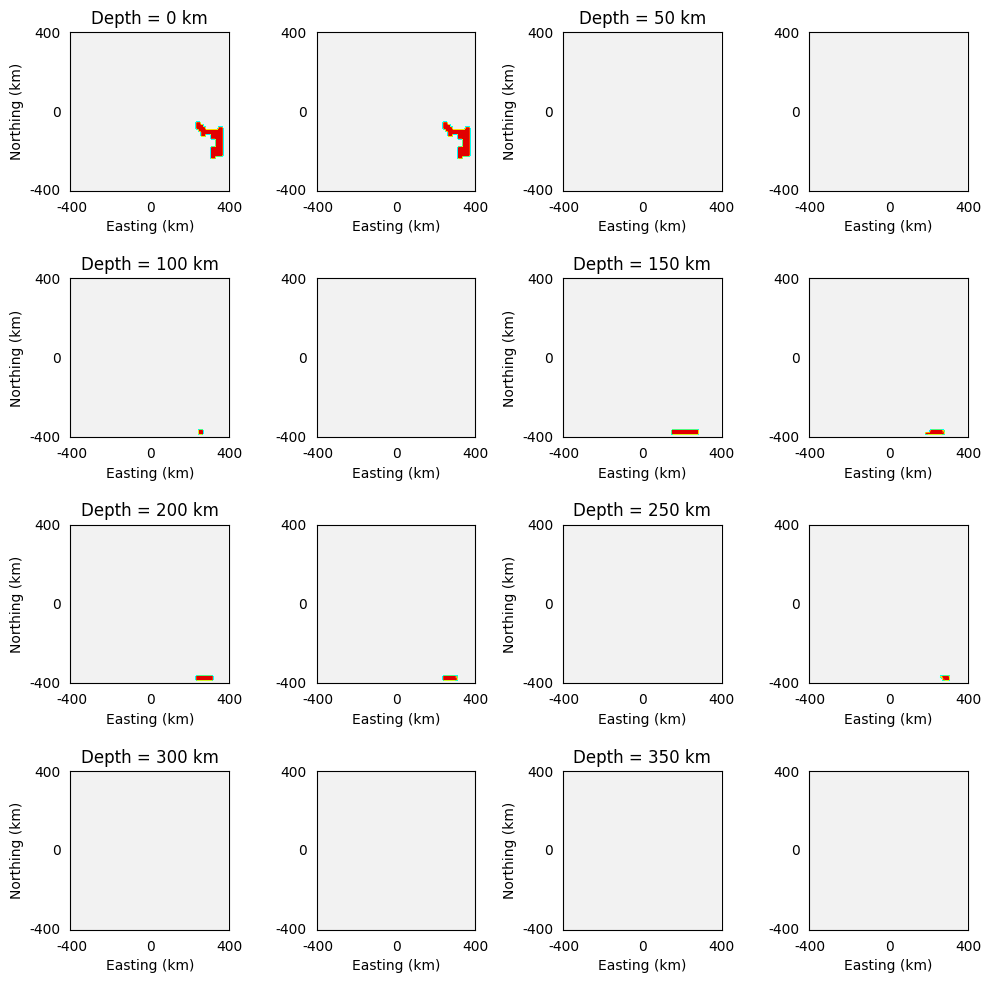

In [96]:
plt.figure(figsize=(10, 10))
for i, depth in enumerate(range(0, 32, 4)):
    ax = plt.subplot(4, 4, 2 * i + 1)
    plt.title("Depth = {:.0f} km".format(depth * 400 / 32), fontsize=12)
    plot_xoy(y_train[idx], depth)

    ax = plt.subplot(4, 4, 2 * i + 2)
    plot_xoy(predict[idx], depth, ylabel=False, factor=0.6)
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.tight_layout()
plt.savefig(os.path.join(model_dir, "dcm_compare_{}".format(idx)))
plt.show()

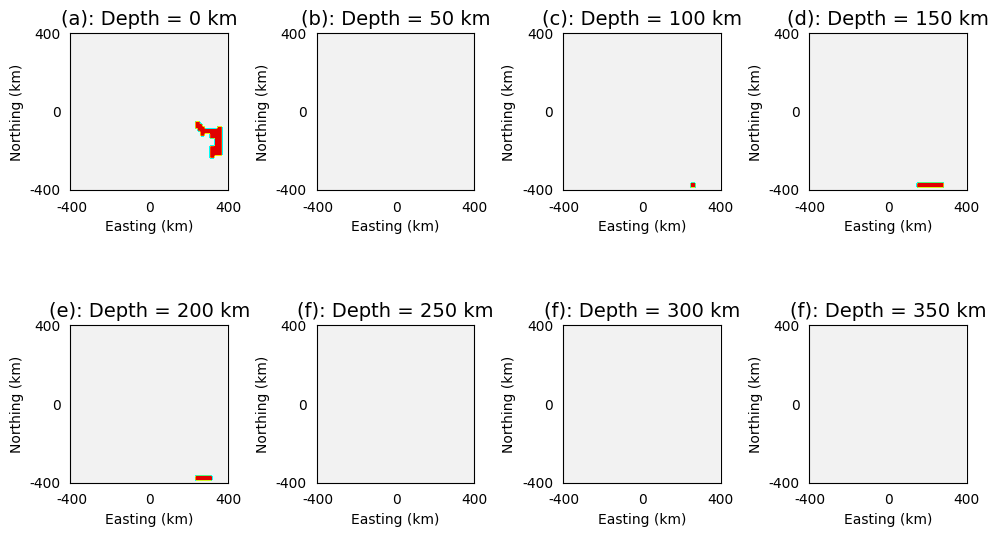

In [97]:
# plt.rc('font',family = 'Times New Roman', size = 14)
indexes = [0, 4, 8, 12, 16, 20, 24, 28]
plt.figure(figsize = (10, 6))
plt.subplot(241)
plot_xoy(np.around(y_train[idx], decimals=1), indexes[0])
plt.title("(a): Depth = 0 km", fontsize=14)
plt.subplot(242)
plot_xoy(np.around(y_train[idx], decimals=1), indexes[1])
plt.title("(b): Depth = 50 km", fontsize=14)
plt.subplot(243)
plot_xoy(np.around(y_train[idx], decimals=1), indexes[2])
plt.title("(c): Depth = 100 km", fontsize=14)
plt.subplot(244)
plot_xoy(np.around(y_train[idx], decimals=1), indexes[3])
plt.title("(d): Depth = 150 km", fontsize=14)
plt.subplot(245)
plot_xoy(np.around(y_train[idx], decimals=1), indexes[4])
plt.title("(e): Depth = 200 km", fontsize=14)
plt.subplot(246)
plot_xoy(np.around(y_train[idx], decimals=1), indexes[5])
plt.title("(f): Depth = 250 km", fontsize=14)
plt.subplot(247)
plot_xoy(np.around(y_train[idx], decimals=1), indexes[6])
plt.title("(f): Depth = 300 km", fontsize=14)
plt.subplot(248)
plot_xoy(np.around(y_train[idx], decimals=1), indexes[7])
plt.title("(f): Depth = 350 km", fontsize=14)
plt.tight_layout()
# plt.savefig(os.path.join(model_dir, "real_2d_{}".format(idx)))
plt.show()

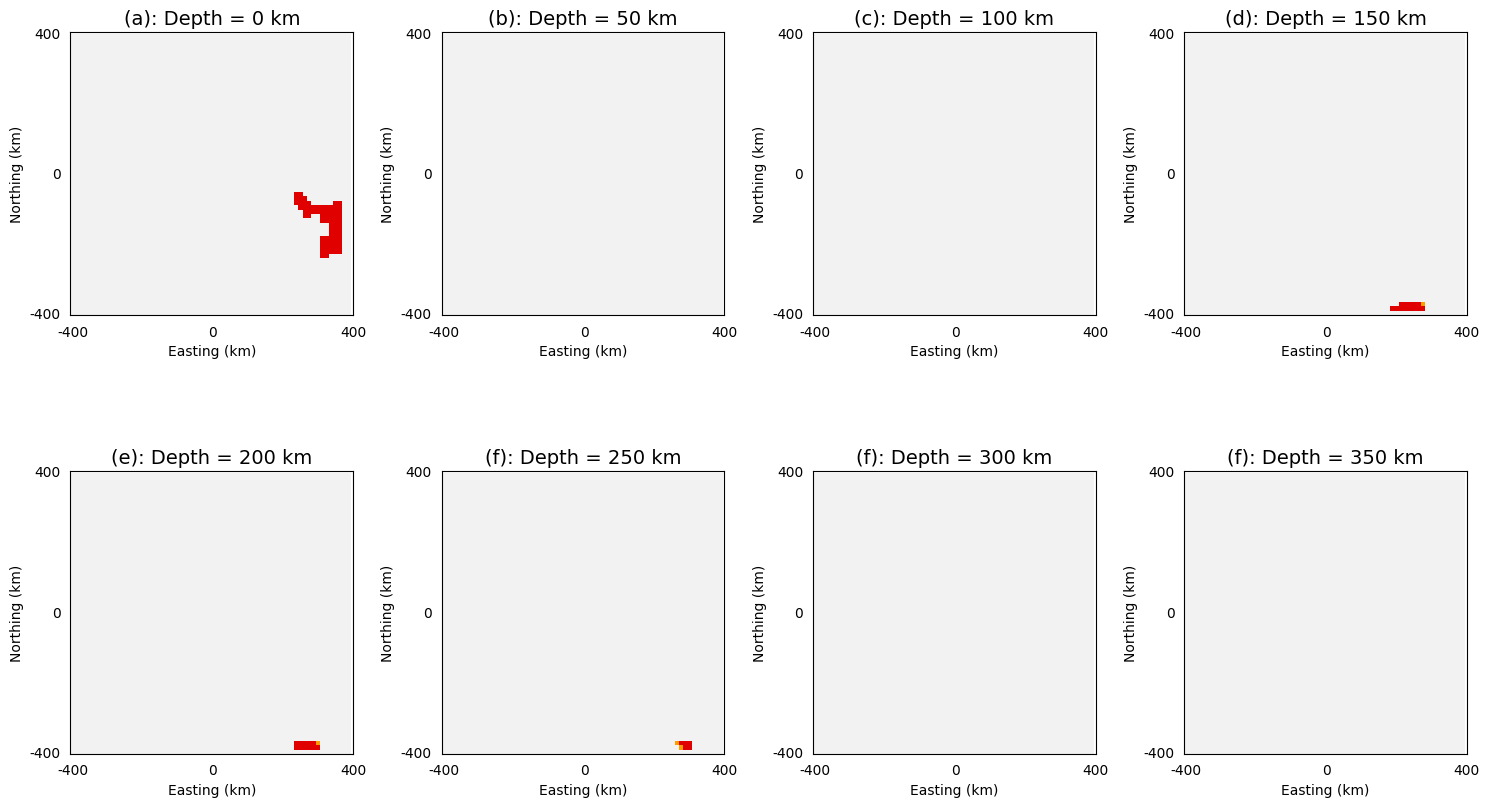

In [98]:
# plt.rc('font',family = 'Times New Roman', size = 14)
indexes = [0, 4, 8, 12, 16, 20, 24, 28]
plt.figure(figsize = (15, 9))
plt.subplot(241)
plot_xoy(np.around(predict[idx], decimals=1), indexes[0])
plt.title("(a): Depth = 0 km", fontsize=14)
plt.subplot(242)
plot_xoy(np.around(predict[idx], decimals=1), indexes[1])
plt.title("(b): Depth = 50 km", fontsize=14)
plt.subplot(243)
plot_xoy(np.around(predict[idx], decimals=1), indexes[2])
plt.title("(c): Depth = 100 km", fontsize=14)
plt.subplot(244)
plot_xoy(np.around(predict[idx], decimals=1), indexes[3])
plt.title("(d): Depth = 150 km", fontsize=14)
plt.subplot(245)
plot_xoy(np.around(predict[idx], decimals=1), indexes[4])
plt.title("(e): Depth = 200 km", fontsize=14)
plt.subplot(246)
plot_xoy(np.around(predict[idx], decimals=1), indexes[5])
plt.title("(f): Depth = 250 km", fontsize=14)
plt.subplot(247)
plot_xoy(np.around(predict[idx], decimals=1), indexes[6])
plt.title("(f): Depth = 300 km", fontsize=14)
plt.subplot(248)
plot_xoy(np.around(predict[idx], decimals=1), indexes[7])
plt.title("(f): Depth = 350 km", fontsize=14)
plt.tight_layout()
# plt.savefig(os.path.join(model_dir, "predict_2d_{}".format(idx)))
plt.show()

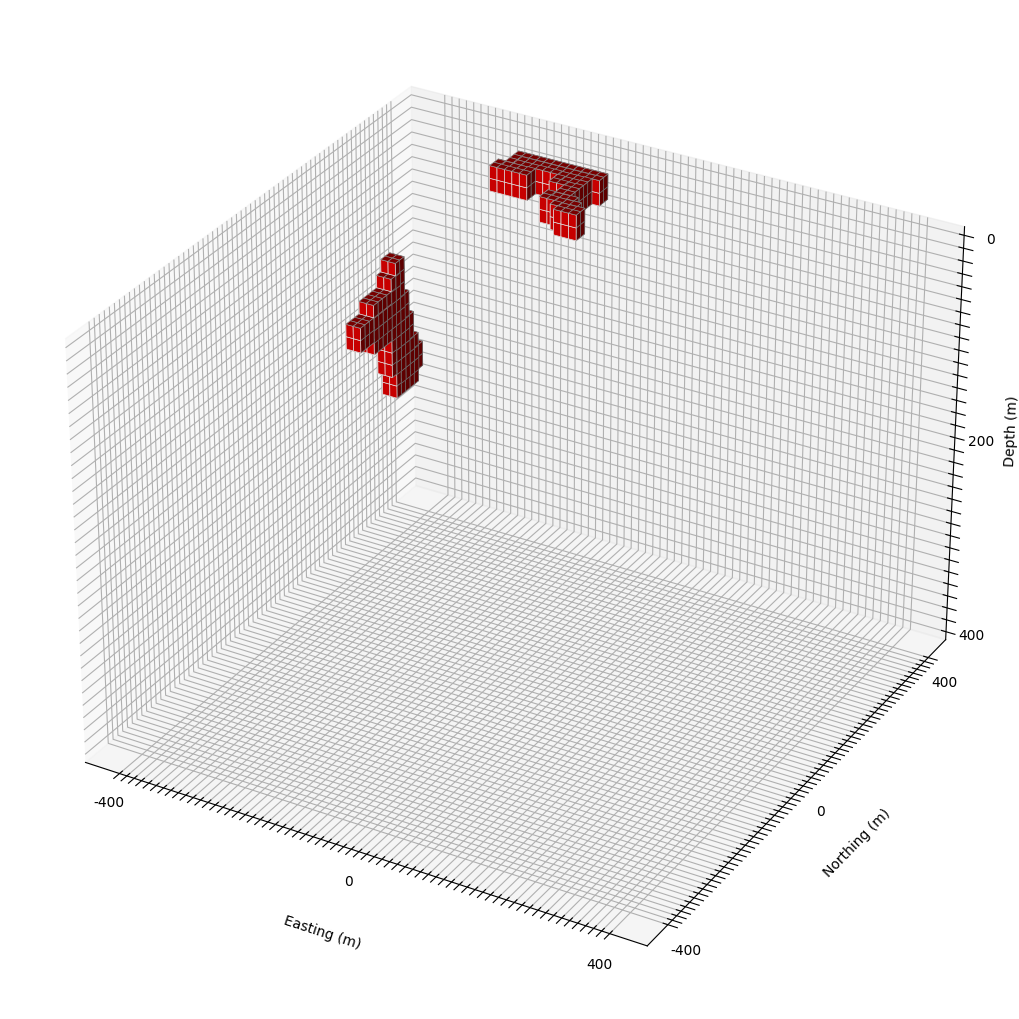

In [99]:
Model(np.transpose(y_train[idx], (2, 0, 1)), 0.2)
plt.savefig(os.path.join(model_dir, "real_3d_{}".format(idx)))
plt.show()

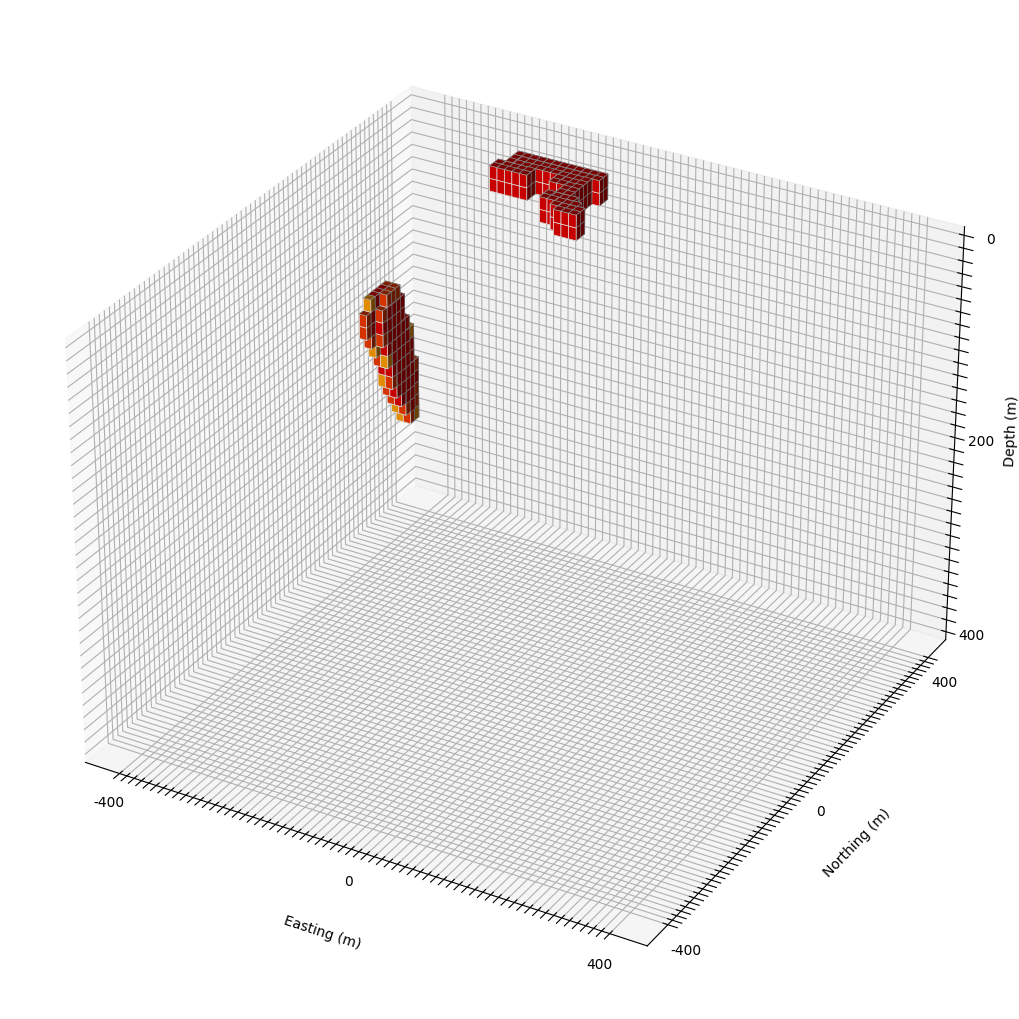

In [104]:
Model(np.transpose(predict[idx], (2, 0, 1)), 0.8)
plt.savefig(os.path.join(model_dir, "predict_3d_{}".format(idx)))
plt.show()

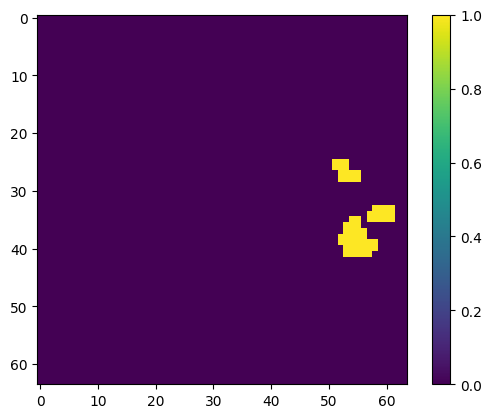

In [101]:
plt.imshow(y_train[idx+2][:, :, 15])
plt.colorbar()

In [102]:
y_train[idx][:, :, depth]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

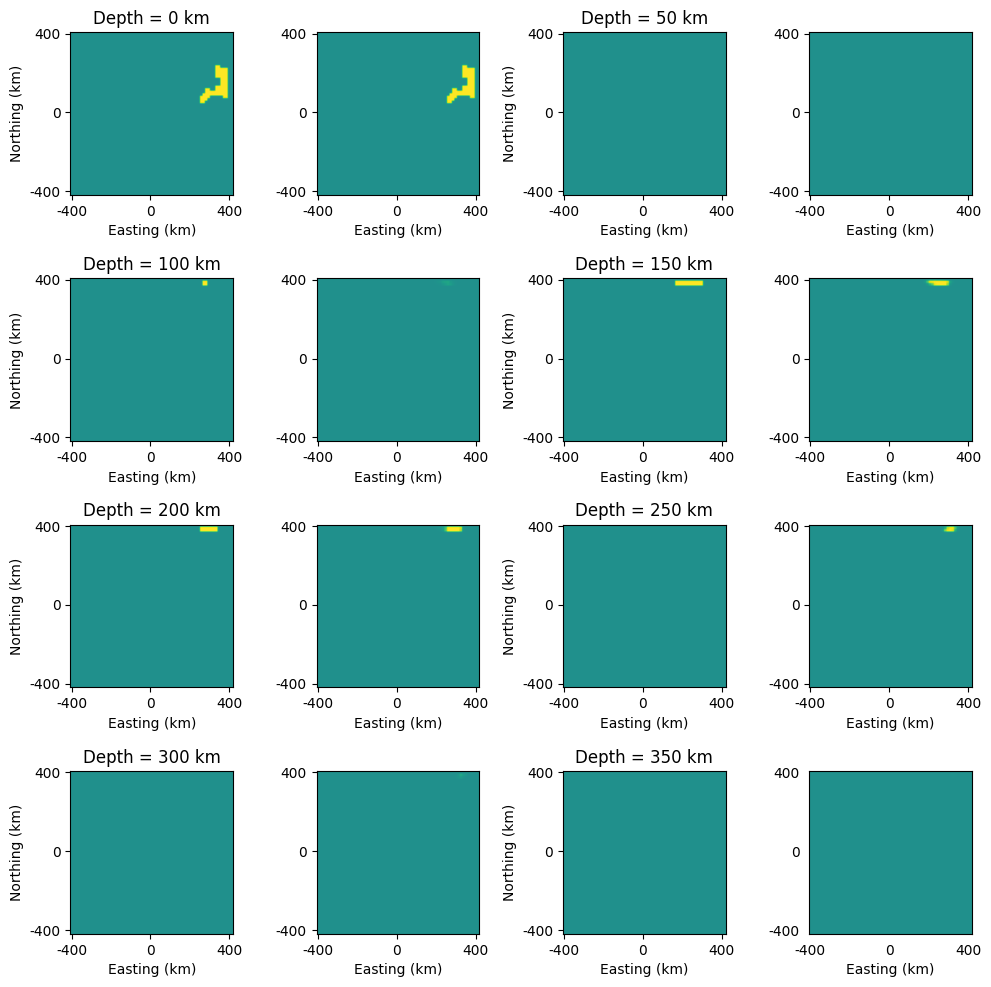

In [103]:
plt.figure(figsize=(10, 10))
for i, depth in enumerate(range(0, 32, 4)):
    ax = plt.subplot(4, 4, 2 * i + 1)
    plt.title("Depth = {:.0f} km".format(depth * 400 / 32), fontsize=12)
    ax.invert_yaxis()
    plt.xticks(np.arange(0, 65, 31), ('-400', '0', '400'))
    plt.xlabel('Easting (km)')
    plt.yticks(np.arange(0, 65, 31), ('400', '0', '-400'))
    plt.ylabel('Northing (km)')
    plt.imshow(y_train[idx][:, :, depth].T, vmin=-1, vmax=1)
    
    # plt.colorbar()
    ax = plt.subplot(4, 4, 2 * i + 2)
    ax.invert_yaxis()
    plt.xticks(np.arange(0, 65, 31), ('-400', '0', '400'))
    plt.xlabel('Easting (km)')
    plt.yticks(np.arange(0, 65, 31), ('400', '0', '-400'))
    plt.imshow(predict[idx][:, :, depth].T, vmin=-1, vmax=1)
    # plt.colorbar()
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.tight_layout()
plt.savefig(os.path.join(model_dir, "cm_compare_{}".format(idx)))
plt.show()

In [39]:
idx = 3000

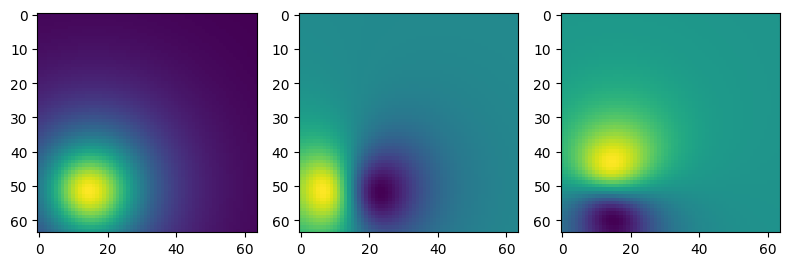

In [42]:
plt.figure(figsize=(8, 4))
ax = plt.subplot(131)
plt.imshow(X_train[idx][:, :, 0].T)
# ax.invert_yaxis()

ax = plt.subplot(132)
plt.imshow(X_train[idx][:, :, 1].T)
# ax.invert_yaxis()

ax = plt.subplot(133)
plt.imshow(X_train[idx][:, :, 2].T)
# ax.invert_yaxis()
plt.tight_layout()
plt.show()

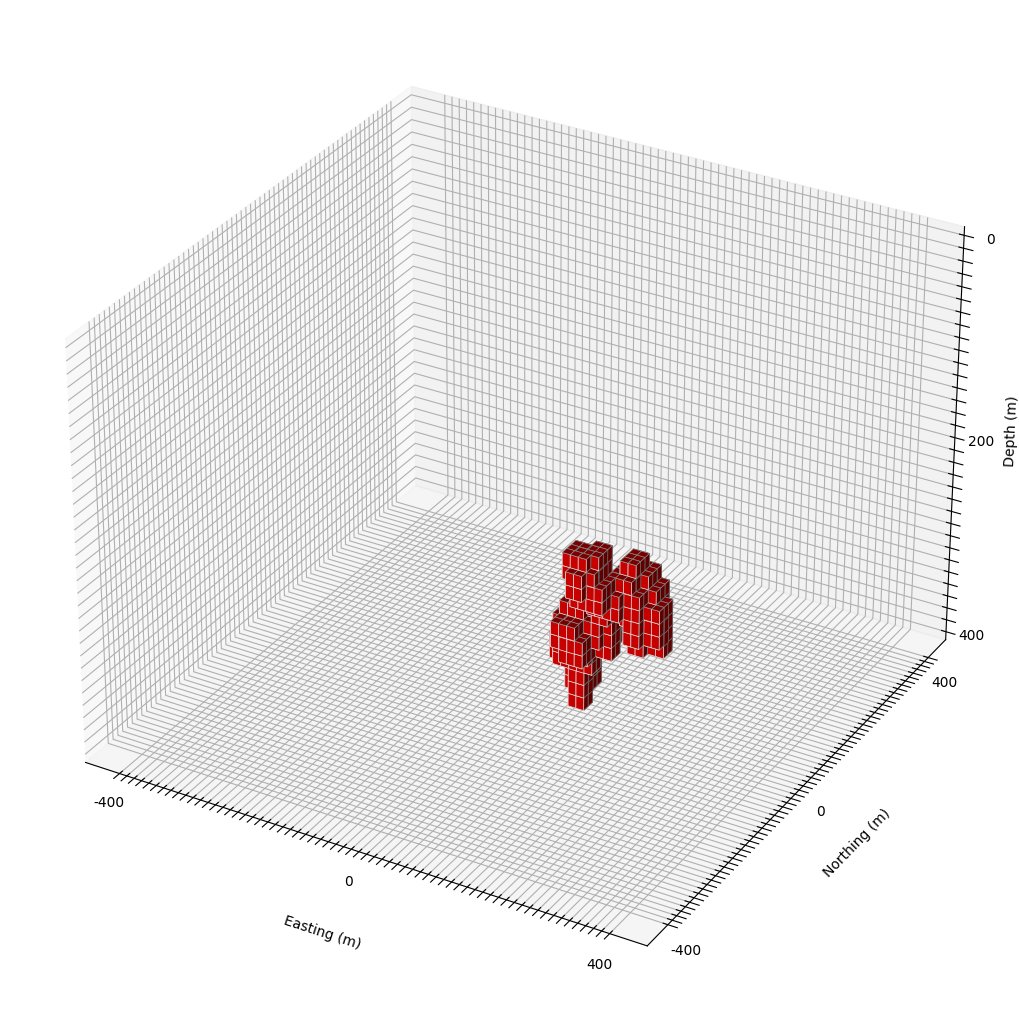

In [41]:
Model(np.transpose(y_train[idx], (2, 0, 1)), 0.8)